In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from torchtext import *
from fastai.nlp import *

## Language modeling

### Data

In [6]:
PATH='../data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

!ls {PATH}

imdbEr.txt  imdb.vocab	models	README	test  train


In [7]:
reviews = os.listdir(TRN)
reviews[:10]

['39562_0.txt',
 '30412_0.txt',
 '17303_0.txt',
 '6261_8.txt',
 '11598_0.txt',
 '9112_1.txt',
 '45517_0.txt',
 '3068_0.txt',
 '4539_9.txt',
 '10096_7.txt']

In [8]:
with open(f'{TRN}{reviews[10]}') as f:
    review = f.read()
review

'LOL, I know I stole that line from I love the 70\'s, but I just thought it was so true and that was my exact thought from the first minute I started watching The Bad News Bears. Now to the movie, The Bad News Bears is one of the funniest movies I have seen in a long time, I almost died laughing throughout the whole movie. I obviously heard about this movie from the show I love the 70\'s on VH1, way before the remake with Billy Bob Thorton. It always slipped my mind though when I wanted to rent it, but finally I remembered and I am so glad that I got the chance to see it, because this is one of the best comedies to come out of the 70\'s.<br /><br />Buttermaker is a has been baseball player and now an alcoholic, he is given the job of a little league coach for the Bears since no other fathers are taking the job. But he\'s definitely taken back when he finds out that the team he is coaching are kids who are, well, I guess you could say "lacking" in the department of knowing how to play b

## Toknize all the file with spacy toknizer, and build language data

In [12]:
review_tok = spacy_tok(review)
' '.join(review_tok)

'LOL , I know I stole that line from I love the 70 \'s , but I just thought it was so true and that was my exact thought from the first minute I started watching The Bad News Bears . Now to the movie , The Bad News Bears is one of the funniest movies I have seen in a long time , I almost died laughing throughout the whole movie . I obviously heard about this movie from the show I love the 70 \'s on VH1 , way before the remake with Billy Bob Thorton . It always slipped my mind though when I wanted to rent it , but finally I remembered and I am so glad that I got the chance to see it , because this is one of the best comedies to come out of the 70 \'s . \n\n Buttermaker is a has been baseball player and now an alcoholic , he is given the job of a little league coach for the Bears since no other fathers are taking the job . But he \'s definitely taken back when he finds out that the team he is coaching are kids who are , well , I guess you could say " lacking " in the department of knowin

In [13]:
TEXT = data.Field(lower=True, tokenize = spacy_tok)

In [14]:
bs = 64
bptt = 70

In [21]:
FILES = dict(train = TRN_PATH, validation = VAL_PATH, test = VAL_PATH)

In [22]:
%time md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt = bptt, min_freq = 10)

CPU times: user 3min, sys: 6.84 s, total: 3min 7s
Wall time: 3min 59s


In [29]:
TEXT.vocab.stoi['the']

2

In [26]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'it', 'in']

In [36]:
(len(md.trn_dl),md.nt, len(md.trn_ds[0].text))

(4603, 34933, 20626674)

In [38]:
' '.join(md.trn_ds[0].text[:12])

'at first , i thought this was a sequel to entre nous'

In [41]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
    40
   101
     3
    12
   212
    13
    19
     6
   685
     8
 32335
     0
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [46]:
next(md.trn_dl)

(Variable containing:
     40   8328     16  ...     613     98      4
    101     72      6  ...       2      8      8
      3    674    759  ...     111     79     14
         ...            ⋱           ...         
      7     82     14  ...    1555      3      4
     13     29     16  ...       4     12     18
      3    319      2  ...       2    198    352
 [torch.cuda.LongTensor of size 73x64 (GPU 0)], Variable containing:
    101
     72
      6
   ⋮   
    741
     63
   2391
 [torch.cuda.LongTensor of size 4672 (GPU 0)])

### Train

In [47]:
emb_sz = 200
nh = 500
nl = 3

In [50]:
opt_func = partial(optim.Adam, betas = (0.7,0.99))

In [51]:
learner = md.get_model(opt_func,emb_sz,nh,nl,dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)

In [55]:
learner.reg_fn = partial(seq2seq_reg, alpha = 2, beta = 1)
learner.clip = 0.3

In [56]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▍ | 3907/4603 [17:11<03:03,  3.79it/s, loss=20.9]

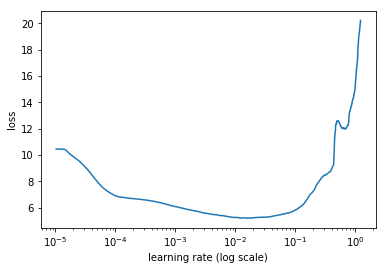

In [57]:
learner.sched.plot()

In [22]:
%time learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      4.805187   4.688053  
    1      4.638915   4.505453                                
    2      4.524203   4.419981                                
    3      4.58589    4.449795                                
    4      4.494019   4.375114                                
    5      4.414522   4.318878                                
    6      4.377372   4.30301                                 
    7      4.520872   4.398838                                
    8      4.488136   4.368702                                
    9      4.450367   4.338311                                
    10     4.406323   4.305835                                
    11     4.377839   4.277589                                
    12     4.340253   4.25297                                 
    13     4.311255   4.238953                                
    14     4.303508   4.236162                                

CPU times: user 4h 34

[4.2361617]

In [69]:
learner.save('adam1')
learner.save_encoder('adam1_enc')

### Test

In [153]:
learner.load('adam1')

Let's see what the top 10 predictions were for the next word after our short text:

In [154]:
m=learner.model
ss='i like this'
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'i like this'

In [155]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [156]:
res,*_ = m(t)

In [157]:
nexts = res[-1].topk(10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['movie', 'film', 'one', 'kind', '.', 'type', ',', 'show', 'series', 'flick']

...and let's see if our model can generate a bit more text all by itself!

In [160]:
print(ss,"\n")
for i in range(100):
    n= res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

i like this 

movie . i 'm not sure if it was a good movie or a good movie , but it was n't . it was a good movie , but it was n't a good movie . it was a good movie . <eos> i saw this movie at the toronto film festival and i was very disappointed . the acting was terrible , the story was terrible , the acting was terrible , the story was terrible , the acting was bad , the story was terrible , the acting was bad , the story was terrible , the acting ...


### Sentiment

In [161]:
IMDB_LABEL = data.Field(sequential=False)

In [163]:
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

downloading aclImdb_v1.tar.gz


In [20]:
t = splits[0].examples[0]

In [21]:
t.label, ' '.join(t.text[:16])

('pos',
 "fantastic documentary of 1924 . this early 20th century geography of today 's iraq was powerful")

In [172]:
md2 = TextData.from_splits(PATH, splits, bs)

In [173]:
m3 = md2.get_model(opt_func, 1500, bptt, emb_sz=emb_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam1_enc')

In [174]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [175]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.154715   1.228566   0.210256  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.475194   0.382867   0.914022  



[0.38286737, 0.9140224358974359]